In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import joblib
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


IMG_HEIGHT = 128
IMG_WIDTH = 128
RAW_DIR = "../data/raw"
PROCESSED_DIR = "../data/processed"
AUGMENTED_DIR = "../data/augmented"
MODEL_DIR = "../models"
NUM_CLASSES = 2  # healthy / diseased

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(AUGMENTED_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)


In [2]:
df = pd.read_csv(os.path.join(RAW_DIR, "train.csv"))
print(" Исходные данные:", df.shape)
df.head()

df["label"] = df.apply(lambda row: 0 if row["healthy"] == 1 else 1, axis=1)
df = df[["image_id", "label"]]

 Исходные данные: (1821, 5)


In [3]:
def load_images(df, folder, size=(128, 128)):
    images_flat = []
    images_cnn = []
    labels = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(folder, row["image_id"] + ".jpg")
        if not os.path.exists(img_path):
            continue
        img = cv2.imread(img_path)
        img = cv2.resize(img, size)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        images_flat.append(img_rgb.flatten())

        images_cnn.append(img_rgb)
        
        labels.append(row["label"])
        
    return (np.array(images_flat), 
            np.array(images_cnn, dtype=np.float32) / 255.0,  # нормализация для CNN
            np.array(labels))

X_flat, X_cnn, y = load_images(df, os.path.join(RAW_DIR, "images"))\

print("Загружено изображений (flatten):", X_flat.shape)
print("Загружено изображений (CNN):", X_cnn.shape)


100%|██████████| 1821/1821 [00:21<00:00, 86.45it/s]


Загружено изображений (flatten): (1821, 49152)
Загружено изображений (CNN): (1821, 128, 128, 3)


In [4]:
y_cnn = to_categorical(y, NUM_CLASSES)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42)



In [6]:
np.save(os.path.join(PROCESSED_DIR, "X_flat.npy"), X_train)
np.save(os.path.join(PROCESSED_DIR, "X_test_flat.npy"), X_test)
np.save(os.path.join(PROCESSED_DIR, "X_cnn.npy"), X_train_cnn)
np.save(os.path.join(PROCESSED_DIR, "X_test_cnn.npy"), X_test_cnn)
np.save(os.path.join(PROCESSED_DIR, "y.npy"), y_train)
np.save(os.path.join(PROCESSED_DIR, "y_test.npy"), y_test)
np.save(os.path.join(PROCESSED_DIR, "y_cnn.npy"), y_train_cnn)
np.save(os.path.join(PROCESSED_DIR, "y_test_cnn.npy"), y_test_cnn)


In [7]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [8]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=200),
    "CNN": "custom"
}


results = {}

In [9]:
X_train = np.load(os.path.join(PROCESSED_DIR, "X_flat.npy"))
X_test = np.load(os.path.join(PROCESSED_DIR, "X_test_flat.npy"))
X_train_cnn = np.load(os.path.join(PROCESSED_DIR, "X_cnn.npy"))
X_test_cnn = np.load(os.path.join(PROCESSED_DIR, "X_test_cnn.npy"))
y_train = np.load(os.path.join(PROCESSED_DIR, "y.npy"))
y_test = np.load(os.path.join(PROCESSED_DIR, "y_test.npy"))
y_train_cnn = np.load(os.path.join(PROCESSED_DIR, "y_cnn.npy"))
y_test_cnn = np.load(os.path.join(PROCESSED_DIR, "y_test_cnn.npy"))

os.makedirs(MODEL_DIR, exist_ok=True)

results = {}

for name, model in models.items():
    print(f"\nОбучение модели: {name}")

    if name != "CNN":
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        results[name] = acc
        print(f"Accuracy {name}: {acc:.4f}")
        joblib.dump(model, os.path.join(MODEL_DIR, f"{name}.joblib"))

    else:
        print("Создание и обучение CNN...")
        cnn_model = create_cnn_model(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
            num_classes=NUM_CLASSES
        )

        history = cnn_model.fit(
            X_train_cnn, y_train_cnn,
            validation_data=(X_test_cnn, y_test_cnn),
            epochs=10,
            batch_size=32,
            verbose=1
        )

        loss, acc = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
        results["CNN"] = acc
        print(f"Accuracy CNN: {acc:.4f}")

        cnn_model.save(os.path.join(MODEL_DIR, "CNN.h5"))



Обучение модели: RandomForest
Accuracy RandomForest: 0.7616

Обучение модели: LogisticRegression
Accuracy LogisticRegression: 0.6603

Обучение модели: CNN
Создание и обучение CNN...


c:\Users\sb170\Desktop\основы программирования\7 семестр\методы анализа данных\работа 3\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.6923 - loss: 0.7455 - val_accuracy: 0.7260 - val_loss: 0.5638
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.7163 - loss: 0.5785 - val_accuracy: 0.7342 - val_loss: 0.5392
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.7198 - loss: 0.5759 - val_accuracy: 0.7288 - val_loss: 0.5362
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.7218 - loss: 0.5563 - val_accuracy: 0.7452 - val_loss: 0.5076
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7672 - loss: 0.5031 - val_accuracy: 0.7589 - val_loss: 0.5082
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.7940 - loss: 0.4542 - val_accuracy: 0.7671 - val_loss: 0.5113
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.8098 - loss: 0.3933 - val_accuracy: 0.7589 - val_loss: 0.5204
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.8613 - loss: 0.3234 - val_accuracy: 0.7699 

Accuracy CNN: 0.7288


In [10]:
metrics = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
metrics.to_csv("metrics.csv", index=False)
metrics

,Model,Accuracy
0,RandomForest,0.761644
1,LogisticRegression,0.660274
2,CNN,0.728767


In [11]:
aug_gen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [12]:

img_folder = os.path.join(RAW_DIR, "images")
save_folder = os.path.join(AUGMENTED_DIR, "images")
os.makedirs(save_folder, exist_ok=True)

aug_images = []
aug_labels = []

In [13]:
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(img_folder, row["image_id"] + ".jpg")
    if not os.path.exists(img_path):
        continue
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img.reshape((1,) + img.shape)
    
    count = 0
    for batch in aug_gen.flow(img, batch_size=1, save_to_dir=save_folder,
                              save_prefix=row["image_id"], save_format='jpg'):
        aug_images.append(batch[0].astype(np.float32)/255.0)  # для CNN
        aug_labels.append(row["label"])
        count += 1
        if count >= 2:
            break

print("Всего аугментированных изображений:", len(aug_images))

np.save(os.path.join(AUGMENTED_DIR, "X_aug_cnn.npy"), np.array(aug_images))
np.save(os.path.join(AUGMENTED_DIR, "y_aug_cnn.npy"), np.array(aug_labels))
print("Аугментированные данные сохранены в:", AUGMENTED_DIR)


100%|██████████| 1821/1821 [00:42<00:00, 42.75it/s]


Всего аугментированных изображений: 3642
Аугментированные данные сохранены в: ../data/augmented


In [14]:
from sklearn.preprocessing import StandardScaler
X_aug_flat = np.array([img.flatten() for img in aug_images])
y_aug_flat = np.array(aug_labels)

X_all_flat = np.concatenate([X_flat, X_aug_flat])
y_all_flat = np.concatenate([y, y_aug_flat])

X_train2_flat, X_test2_flat, y_train2_flat, y_test2_flat = train_test_split(
    X_all_flat, y_all_flat, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train2_flat_scaled = scaler.fit_transform(X_train2_flat)
X_test2_flat_scaled = scaler.transform(X_test2_flat)
X_aug_cnn = np.array(aug_images)
y_aug_cnn = tf.keras.utils.to_categorical(aug_labels, num_classes=NUM_CLASSES)

X_train2_cnn = np.concatenate([X_train_cnn, X_aug_cnn])
y_train2_cnn = np.concatenate([y_train_cnn, y_aug_cnn])

X_test2_cnn = X_test_cnn
y_test2_cnn = y_test_cnn

In [15]:
results_aug = {}

for name, model in models.items():
    print(f"\nОбучение модели (аугм. данные): {name}")
    
    if name != "CNN":
        model.fit(X_train2_flat, y_train2_flat)
        preds = model.predict(X_test2_flat)
        acc = accuracy_score(y_test2_flat, preds)
        results_aug[name] = acc
    else:
        cnn_model = create_cnn_model((IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
        cnn_model.fit(
            X_train2_cnn, y_train2_cnn,
            validation_data=(X_test2_cnn, y_test2_cnn),
            epochs=10,
            batch_size=32,
            verbose=1
        )
        loss, acc = cnn_model.evaluate(X_test2_cnn, y_test2_cnn, verbose=0)
        results_aug["CNN"] = acc
        cnn_model.save(os.path.join(MODEL_DIR, "CNN_aug.h5"))
    
    print(f"Accuracy {name} (aug): {results_aug[name]:.4f}")


Обучение модели (аугм. данные): RandomForest
Accuracy RandomForest (aug): 0.7566

Обучение модели (аугм. данные): LogisticRegression


c:\Users\sb170\Desktop\основы программирования\7 семестр\методы анализа данных\работа 3\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy LogisticRegression (aug): 0.6944

Обучение модели (аугм. данные): CNN


c:\Users\sb170\Desktop\основы программирования\7 семестр\методы анализа данных\работа 3\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.7093 - loss: 0.6622 - val_accuracy: 0.7260 - val_loss: 0.5875
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.7156 - loss: 0.5901 - val_accuracy: 0.7260 - val_loss: 0.5983
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.7169 - loss: 0.5822 - val_accuracy: 0.7342 - val_loss: 0.5180
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.7311 - loss: 0.5470 - val_accuracy: 0.7288 - val_loss: 0.5329
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.7464 - loss: 0.5180 - val_accuracy: 0.7479 - val_loss: 0.5059
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.7715 - loss: 0.4733 - val_accuracy: 0.6740 - val_loss: 0.6076
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8040 - loss: 0.4238 - val_accuracy: 0.7479 - val_loss: 0.5376
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.8368 - loss: 0

Accuracy CNN (aug): 0.6904



Сравнение точностей:


,Model,Accuracy,Accuracy (Augmented)
0,RandomForest,0.761644,0.756633
1,LogisticRegression,0.660274,0.694419
2,CNN,0.728767,0.690411


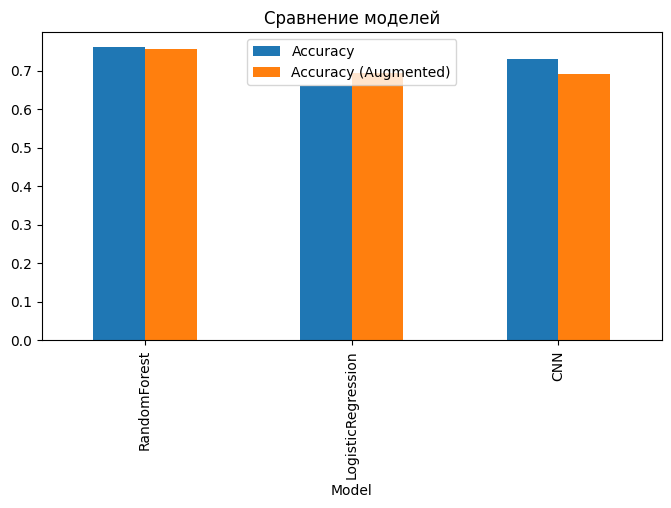

In [16]:
metrics_aug = pd.DataFrame(list(results_aug.items()), columns=["Model", "Accuracy (Augmented)"])
metrics_aug.to_csv("metrics_aug.csv", index=False)

merged = pd.merge(metrics, metrics_aug, on="Model")
print("\nСравнение точностей:")
display(merged)

merged.plot(x="Model", y=["Accuracy", "Accuracy (Augmented)"], kind="bar",
            figsize=(8,4), title="Сравнение моделей")
plt.show()